<a href="https://colab.research.google.com/github/royam0820/Accessing-and-modifying-different-layers-of-a-pretrained-model-in-pytorch/blob/master/amr_stable_conceptualizer_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Conceptualizer - Stable Diffusion using learned concepts

The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 
Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). 


## Initial setup

In [1]:
#@title Install the required libs
!pip install -qq diffusers==0.4.1 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 229 kB 14.7 MB/s 
     |████████████████████████████████| 5.5 MB 68.4 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 182 kB 89.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 
     |████████████████████████████████| 1.6 MB 12.7 MB/s 


In [2]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [4]:
#@title Import required libraries
import os
import torch

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#). 



In [5]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [7]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/birb-style" #@param {type:"string"}


#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
  os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
  embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
  token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
  !cp $embeds_path $downloaded_embedding_folder
  !cp $token_path $downloaded_embedding_folder
  with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()
else:
  !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

Downloading:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.0 [00:00<?, ?B/s]

## The placeholder token for your concept is `<birb-style>`

https://huggingface.co/sd-concepts-library/birb-style

In [8]:
#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16
)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

In [9]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds
load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

In [10]:
#@title Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    revision="fp16",
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
).to("cuda")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

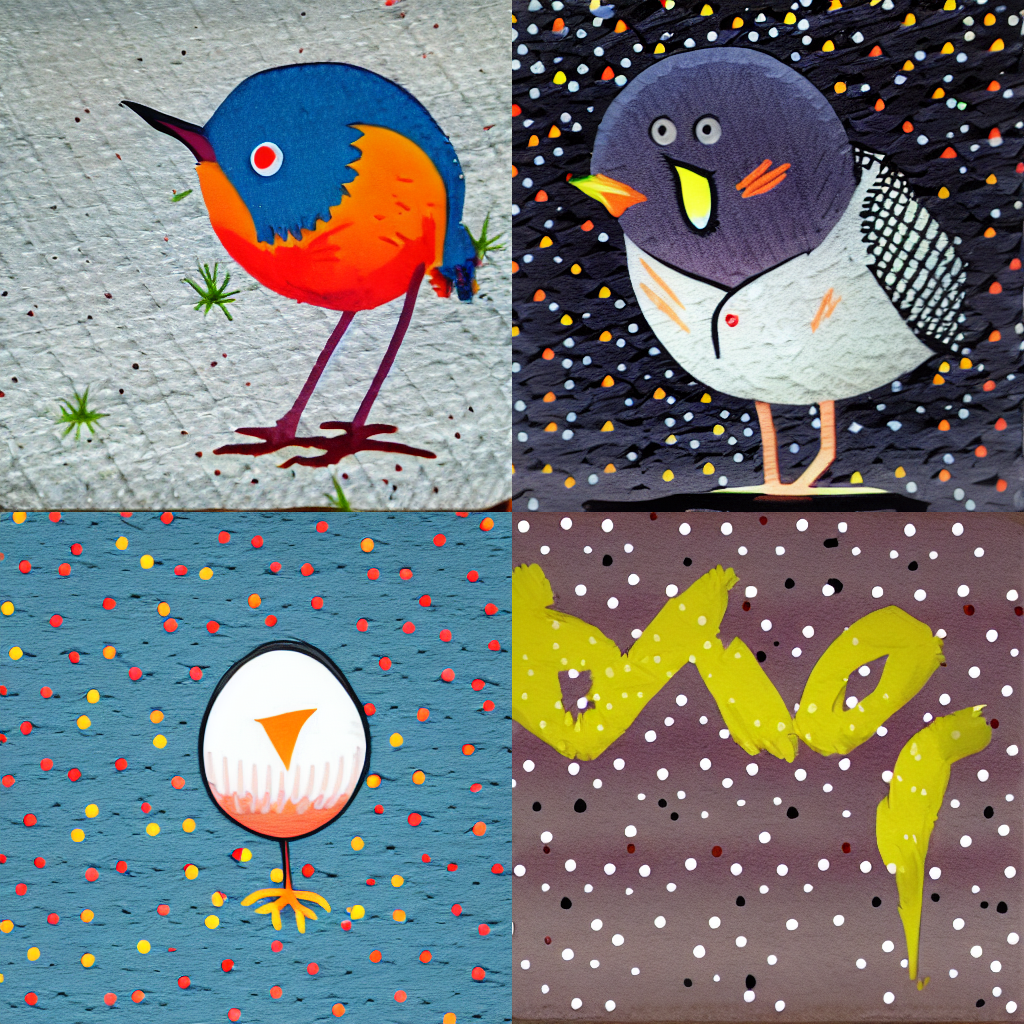

In [11]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a tweet in the style of \u003Cbirb-style>" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5)["sample"]
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid